In [68]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt
import statsmodels.api as sm

In [32]:
#acquire data
url = 'https://ds.codeup.com/saas.csv'
df = pd.read_csv(url)
print('shape:', df.shape)


shape: (790458, 5)


In [33]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [34]:
#fix ugly column names and change to datetime format
# Lowercase column names
df.columns = [col.lower() for col in df]
# Properly parse the datetime field
df.month_invoiced = pd.to_datetime(df.month_invoiced)

In [35]:
#fix dtypes and set index as the date
df.subscription_type = df.subscription_type.astype(int)
df.amount = df.amount.astype(int)
df = df.set_index('month_invoiced')

[Text(0.5, 1.0, 'Revenue Over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

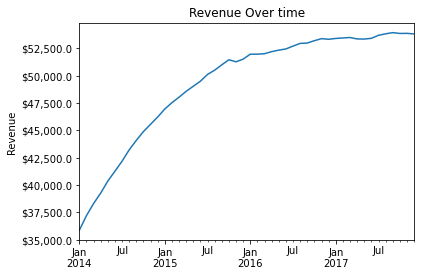

In [36]:
# a quick look at revenue over time
ax = df.resample('M').amount.sum().plot()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')

In [37]:
#resample to monthly 
df = df.resample('M')[["amount"]].sum()

In [38]:
#split into train, validate, test using the .5, .3, .2 percentage splits
#this is the percentage split method
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)


In [10]:
#use the below to split the data frame
print(train_size, validate_size, test_size)

24 14 10


In [39]:
# set end for validate
validate_end_index = train_size + validate_size
validate_end_index

38

In [40]:
#train will go from 0 to 23 (0 to train_size)
train = df[:train_size]
#validate will go from 24 to 37 (train_size to train_size + validate_size)
validate = df[train_size: validate_end_index]

In [41]:
#the last split
test = df[validate_end_index:]

In [15]:
train

month_invoiced
2014-01-31    35850
2014-02-28    37190
2014-03-31    38295
2014-04-30    39255
2014-05-31    40355
2014-06-30    41255
2014-07-31    42170
2014-08-31    43210
2014-09-30    44075
2014-10-31    44880
2014-11-30    45545
2014-12-31    46210
2015-01-31    46945
2015-02-28    47520
2015-03-31    48025
2015-04-30    48560
2015-05-31    49025
2015-06-30    49485
2015-07-31    50105
2015-08-31    50495
2015-09-30    50985
2015-10-31    51445
2015-11-30    51260
2015-12-31    51505
Freq: M, Name: amount, dtype: int64

In [16]:
train.size

24

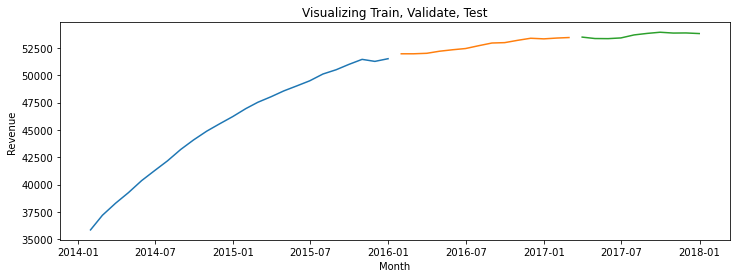

In [42]:
#plot the data points, color by train, validate, test
plt.figure(figsize=(12, 4))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.ylabel('Revenue')   
plt.xlabel('Month')
plt.title('Visualizing Train, Validate, Test')
plt.show()

In [43]:
#some functions for evaluating the model
#compute the rmse and mean squared error
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [44]:
#this combined with the above function will plot train and test values with the predicted values in order to compare performance
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [45]:
#create an empty dataframe for evaluation
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])


In [46]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [ ]:
#forcasting

In [47]:
train.head()

,amount
month_invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


In [48]:
#last observed value (just uses the last known value for the prediction)
#take the last item of the train variable and assign it to yhat_df['amount']
amount = train['amount'][-1:][0]
yhat_df = pd.DataFrame({'amount': [amount]},
                          index = validate.index)   
#this sets the index of yhat_df to match the validate index and then adds the amount to it which is the last amount in the train data set

amount -- RMSE: 1343


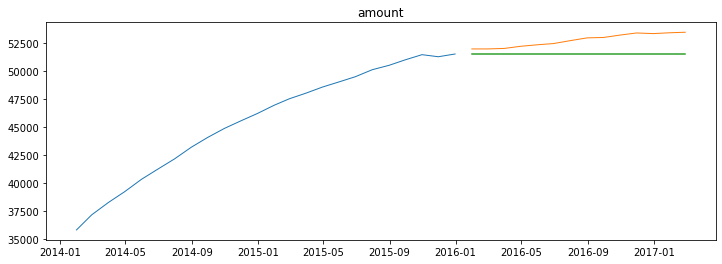

In [50]:
#use the plot_and_eval function to visualize the train, validate, and predicted values
plot_and_eval('amount')


amount -- RMSE: 1343


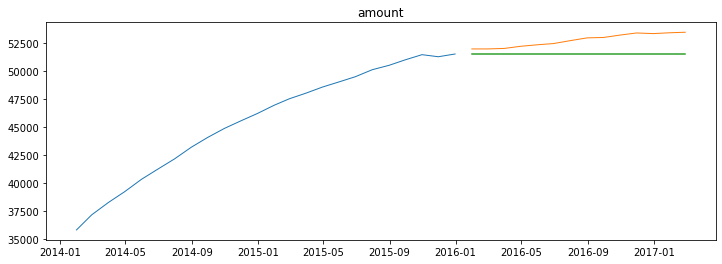

In [51]:
for col in train.columns:
    plot_and_eval(col)  

In [52]:
#evaluate using MSE and RMSE and add to eval_df created earlier
for col in train.columns:
    eval_df = append_eval_df(model_type='last_observed_value', target_var = col)


In [53]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


In [54]:
#simple average (uses the average of all the values in the train set for the prediction)
#compute the average amount
amount = round(train['amount'].mean(), 2)


In [55]:
amount

45568.54

In [56]:
#a function to create the simple average dataframe 
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index=validate.index)
    return yhat_df


In [60]:
yhat_df = make_predictions(amount)

amount -- RMSE: 7181


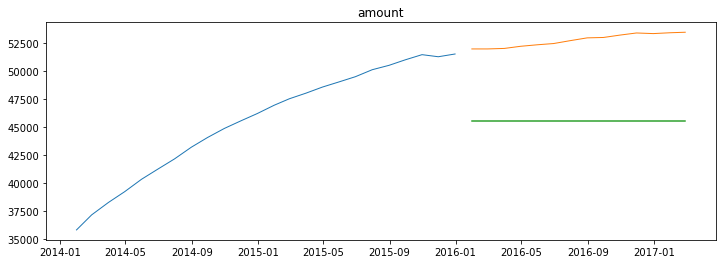

In [61]:
#plot actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [62]:
#add to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0


In [63]:
#rolling average (uses the average of the last 90 days (3 month) of the train set for the prediction)
#compute the rolling average and save as amount
period = 3
amount = round(train['amount'].rolling(period).mean()[-1], 2)
amount

51403.33

In [64]:
#save to yhat_df
yhat_df = make_predictions(amount)


amount -- RMSE: 1436


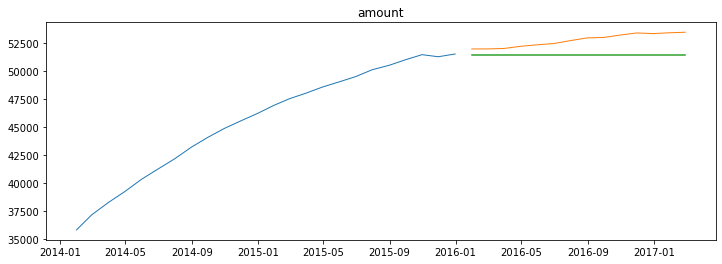

In [65]:
#plot actual vs. predicted values
for col in train.columns:
    plot_and_eval(col)

In [66]:
#add to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type='rolling_average',target_var = col)

In [67]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple_average,amount,7181.0
2,rolling_average,amount,1436.0


In [ ]:
#holts linear trend

amount 



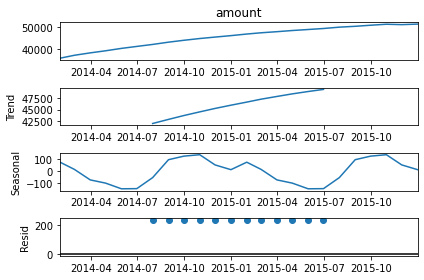

In [69]:
#looking at eacth targets seasonal decomposition
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [ ]:
#make predictions

### Some hyperprims:
Holt:

* exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
* damped = True/False: with Holt, forecasts will increase or decrease indefinitely into the future. To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1.

fit:

* smoothing_level: value between (0,1)
* smoothing_slope: value between (0,1)
* optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

In [70]:
col = 'amount'
#create the model object
model = Holt(train[col], exponential=False, damped=True)
#fit the model
model = model.fit(optimized=True)
#predict
yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])

In [71]:
yhat_df[col] = round(yhat_items, 2) 

amount -- RMSE: 456


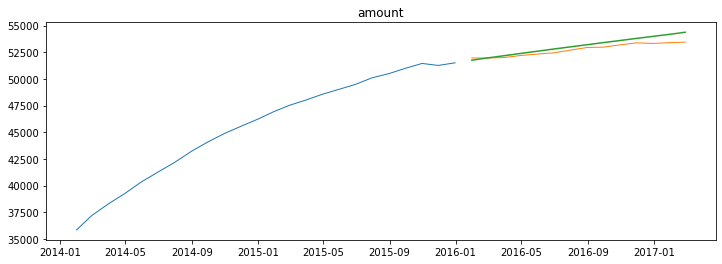

In [72]:
#plot actual vs. predicted values
plot_and_eval(target_var=col)

In [73]:
#evaluate
eval_df = append_eval_df(model_type='holts_optimized', target_var = col)

In [74]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
3,holts_optimized,amount,456.0
0,last_observed_value,amount,1343.0
2,rolling_average,amount,1436.0
1,simple_average,amount,7181.0
